# 雨量站資料分析（DuckDB + CSV）

本 Notebook 示範如何使用 DuckDB 與 pandas（直接讀取 CSV）對同一份雨量站資料執行相同分析，方便比較兩種流程。


## 使用方式

1. 建議先在 `Duck_DB` 目錄建立虛擬環境並安裝 `duckdb`、`pandas`、`jupyter`
2. 執行 `python build_rain_duckdb.py` 建立 `rainfall.duckdb`
3. 打開此 Notebook，照順序執行各 Cell
4. 若資料檔案更新，可再跑一次建表腳本或在 Notebook 內重新執行對應 Cell


In [1]:
from pathlib import Path
import subprocess
import sys

import duckdb
import pandas as pd

# Notebook 使用的所有路徑都集中設定在此區塊，方便換資料夾時一起調整。
BASE_DIR = Path('.').resolve()
DATA_DIR = BASE_DIR / 'data'
CSV_PATH = DATA_DIR / 'Rain_1998-2017.csv'
DB_PATH = BASE_DIR / 'rainfall.duckdb'
BUILD_SCRIPT = BASE_DIR / 'build_rain_duckdb.py'

# 先輸出關鍵檔案路徑，確保 Notebook 在預期的資料夾執行。
print(f"資料來源: {CSV_PATH}")
print(f"DuckDB 檔案: {DB_PATH}")

# 連接到 DuckDB 資料庫
conn = duckdb.connect(str(DB_PATH))
conn.execute("PRAGMA enable_progress_bar=0")



資料來源: /home/NAS/homes/pinghung-10018/Course_data/Wangthon/Duck_DB/data/Rain_1998-2017.csv
DuckDB 檔案: /home/NAS/homes/pinghung-10018/Course_data/Wangthon/Duck_DB/rainfall.duckdb


In [2]:
print(f"  檔案大小: {DB_PATH.stat().st_size / 1e9:.2f} GB")

  檔案大小: 0.26 GB


## DuckDB 資料預覽

先看一下 DuckDB 中的雨量資料與對應的 metadata 表，建立對資料庫內容的直覺。


### DuckDB 內所有表格

利用 `information_schema.tables` 可以快速查看目前資料庫有哪些表格。


In [3]:
# 查看目前 schema 內的資料表，確認 DuckDB 初始化成功。
conn.sql(
    """
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
    ORDER BY table_schema, table_name
    """
).df()


,table_schema,table_name
0,main,annual_maxima
1,main,annual_maxima_wide
2,main,metadata_fields
3,main,metadata_special_values
4,main,rainfall_hourly
5,main,station_coverage_summary


In [4]:
# 抽樣檢視 rainfall_hourly 資料的欄位與時間戳。
conn.sql(
    """
    SELECT station_no, obs_ts, rainfall_mm
    FROM rainfall_hourly
    ORDER BY obs_ts
    LIMIT 5
    """
).df()


,station_no,obs_ts,rainfall_mm
0,466900,1998-01-01 01:00:00,0.0
1,467571,1998-01-01 01:00:00,0.0
2,C0A950,1998-01-01 01:00:00,0.0
3,C0A880,1998-01-01 01:00:00,0.0
4,C0A970,1998-01-01 01:00:00,0.0


In [5]:
#查看表格結構
schema = conn.sql("DESCRIBE rainfall_hourly").df()
print(schema)

   column_name column_type null   key default extra
0   station_no     VARCHAR  YES  None    None  None
1       obs_ts   TIMESTAMP  YES  None    None  None
2  rainfall_mm      DOUBLE  YES  None    None  None


**主要欄位說明**：

| 欄位名稱 | 資料型別 | 單位 | 說明 |
|---------|---------|------|------|
| `station_no` | VARCHAR | - | 測站代碼（唯一識別碼） |
| `dobs_ts` | TIMESTAMP | - | 觀測時間（台灣標準時間 UTC+8） |
| `rainfall_mm` | DOUBLE | mm | 過去 1 小時累積雨量 |

In [6]:
# 驗證 metadata_fields 內容，方便後續查詢對照欄位說明。
conn.sql(
    """
    SELECT * FROM metadata_fields
    ORDER BY code
    LIMIT 10
    """
).df()


,code,description
0,CD01,高雲高度(Km)
1,CD02,中雲高度(Km)
2,CD03,低雲高度(Km)
3,CD04,高雲量(10分量)
4,CD05,中雲量(10分量)
5,CD06,低雲量(10分量)
6,CD07,高雲狀
7,CD08,中雲狀
8,CD09,低雲狀
9,CD10,雲冪高(Km)


In [7]:
# 列出特殊值對照表，了解 -9998 等代表的含義。
conn.sql(
    """
    SELECT * FROM metadata_special_values
    ORDER BY code
    """
).df()


,code,meaning
0,-9991,儀器故障待修
1,-9996,資料累計於後
2,-9997,因不明原因或故障而無資料
3,-9998,雨跡(Trace)
4,-9999,未觀測而無資料


這三張表分別代表：`rainfall_hourly`（主資料）、`metadata_fields`（欄位代碼說明）與 `metadata_special_values`（特殊值說明）。`conn.sql(...).df()` 可以直接把查詢結果變成 DataFrame，方便 Notebook 中展示。接下來進入 DuckDB 與 pandas 的比較分析。


## 載入 CSV（pandas）

為了與 DuckDB 結果比對，同時載入 CSV 形成 `DataFrame`，並將 `yyyymmddhh` 轉成時間戳。


In [8]:
# 從 CSV 讀取所有雨量記錄，並統一欄位名稱與型別。
csv_df = pd.read_csv(
    CSV_PATH,
    dtype={"stno": 'string', "yyyymmddhh": 'string'},
)
csv_df = csv_df.rename(columns={"stno": "station_no", "PP01": "rainfall_mm"})

# 將降雨量轉為數值，並把負值視為 0
csv_df['rainfall_mm'] = pd.to_numeric(csv_df['rainfall_mm'], errors='coerce').clip(lower=0)

# 將時間字串拆分成日期與小時，同時處理 24 點 rollover 的情境。
stamp = csv_df['yyyymmddhh'].fillna('')
dates = pd.to_datetime(stamp.str[:8], format='%Y%m%d', errors='coerce')
hours = pd.to_numeric(stamp.str[-2:], errors='coerce').fillna(0).astype(int)
rollover = hours == 24
hours = hours.where(~rollover, 0)
obs_ts = dates + pd.to_timedelta(hours, unit='h')
obs_ts.loc[rollover] = obs_ts.loc[rollover] + pd.Timedelta(days=1)
csv_df['obs_ts'] = obs_ts

In [9]:
print(csv_df[['station_no', 'obs_ts', 'rainfall_mm']].head(24))

   station_no              obs_ts  rainfall_mm
0      466880 2002-01-01 01:00:00          0.0
1      466880 2002-01-01 02:00:00          0.0
2      466880 2002-01-01 03:00:00          0.0
3      466880 2002-01-01 04:00:00          0.0
4      466880 2002-01-01 05:00:00          0.0
5      466880 2002-01-01 06:00:00          0.0
6      466880 2002-01-01 07:00:00          0.0
7      466880 2002-01-01 08:00:00          0.0
8      466880 2002-01-01 09:00:00          0.0
9      466880 2002-01-01 10:00:00          0.0
10     466880 2002-01-01 11:00:00          0.0
11     466880 2002-01-01 12:00:00          0.0
12     466880 2002-01-01 13:00:00          0.0
13     466880 2002-01-01 14:00:00          0.0
14     466880 2002-01-01 15:00:00          0.0
15     466880 2002-01-01 16:00:00          0.0
16     466880 2002-01-01 17:00:00          0.0
17     466880 2002-01-01 18:00:00          0.0
18     466880 2002-01-01 19:00:00          0.0
19     466880 2002-01-01 20:00:00          0.0
20     466880

上述資料清理步驟會將所有負值（含缺值編碼）歸零，並把 `24` 時段換算成隔天 00:00，確保 DuckDB 與 pandas 使用相同的時間與雨量語意。這個 DataFrame 之後供所有 pandas 版分析使用。


## 分析 1：各測站資料涵蓋範圍

透過 DuckDB 與 pandas 各自計算資料筆數、日期範圍與總雨量。


In [10]:
stations_duckdb = conn.execute(
    """
    SELECT
        station_no,
        MIN(obs_ts) AS first_obs,
        MAX(obs_ts) AS last_obs,
        COUNT(*) AS hourly_records,
        ROUND(SUM(GREATEST(COALESCE(rainfall_mm, 0), 0)), 2) AS total_rainfall_mm
    FROM rainfall_hourly
    GROUP BY station_no
    ORDER BY station_no
    """
).fetchdf()
stations_duckdb


,station_no,first_obs,last_obs,hourly_records,total_rainfall_mm
0,466880,2002-01-01 01:00:00,2018-01-01,140256,37619.0
1,466900,1998-01-01 01:00:00,2018-01-01,175320,43054.0
2,466910,1998-01-01 01:00:00,2018-01-01,175320,97006.2
3,466920,1998-01-01 01:00:00,2018-01-01,175320,49234.6
4,466930,1998-01-01 01:00:00,2018-01-01,175320,84413.0
...,...,...,...,...,...
767,C1Z120,2017-06-07 01:00:00,2018-01-01,4992,1764.5
768,C1Z130,2017-06-07 01:00:00,2018-01-01,4992,1683.5
769,C1Z140,2017-12-30 01:00:00,2018-01-01,48,39.5
770,C1Z240,2017-12-01 01:00:00,2018-01-01,744,174.0


In [11]:
# 以 pandas 重新計算同樣的統計指標，作為 DuckDB 結果的檢核。
stations_csv = (
    csv_df
    .groupby('station_no')
    .agg(
        first_obs=('obs_ts', 'min'),
        last_obs=('obs_ts', 'max'),
        hourly_records=('obs_ts', 'size'),
        total_rainfall_mm=('rainfall_mm', 'sum'),
    )
    .reset_index()
    .sort_values('station_no')
)
stations_csv


,station_no,first_obs,last_obs,hourly_records,total_rainfall_mm
0,466880,2002-01-01 01:00:00,2018-01-01,140256,37619.0
1,466900,1998-01-01 01:00:00,2018-01-01,175320,43054.0
2,466910,1998-01-01 01:00:00,2018-01-01,175320,97006.2
3,466920,1998-01-01 01:00:00,2018-01-01,175320,49234.6
4,466930,1998-01-01 01:00:00,2018-01-01,175320,84413.0
...,...,...,...,...,...
767,C1Z120,2017-06-07 01:00:00,2018-01-01,4992,1764.5
768,C1Z130,2017-06-07 01:00:00,2018-01-01,4992,1683.5
769,C1Z140,2017-12-30 01:00:00,2018-01-01,48,39.5
770,C1Z240,2017-12-01 01:00:00,2018-01-01,744,174.0


## 分析 2：指定測站的逐月累積雨量

選擇測站與年份，分別用 DuckDB 與 pandas 彙總每月雨量。


上方兩個結果（DuckDB 與 pandas）應該一致，差異只在於執行方式。這裡可以快速比對欄位與數值是否相符，以確認資料管線同步。


In [12]:
station_id = "466900"  # 站碼需要用字串表示，DuckDB 與 pandas 才能一致比對
analysis_year = 2015
start_ts = f"{analysis_year}-01-01"
end_ts = f"{analysis_year + 1}-01-01"


In [13]:
# DuckDB SQL 聚合指定測站一年內的逐月雨量。
monthly_duckdb = conn.execute(
    """
    SELECT
        DATE_TRUNC('month', obs_ts) AS month_start,
        SUM(GREATEST(COALESCE(rainfall_mm, 0), 0)) AS monthly_rainfall_mm
    FROM rainfall_hourly
    WHERE station_no = ?
      AND obs_ts >= ?
      AND obs_ts < ?
    GROUP BY month_start
    ORDER BY month_start
    """,
    [station_id, start_ts, end_ts],
).fetchdf()
monthly_duckdb


,month_start,monthly_rainfall_mm
0,2015-01-01,20.5
1,2015-02-01,34.0
2,2015-03-01,129.0
3,2015-04-01,89.5
4,2015-05-01,260.0
5,2015-06-01,38.0
6,2015-07-01,102.0
7,2015-08-01,376.0
8,2015-09-01,363.0
9,2015-10-01,67.0


In [14]:
# pandas 版本的逐月統計，應與 SQL 結果一致。
mask = (
    (csv_df['station_no'] == station_id)
    & (csv_df['obs_ts'] >= start_ts)
    & (csv_df['obs_ts'] < end_ts)
)
monthly_csv = (
    csv_df.loc[mask]
    .assign(month_start=lambda df: df['obs_ts'].dt.to_period('M').dt.to_timestamp())
    .groupby('month_start')
    .agg(monthly_rainfall_mm=('rainfall_mm', 'sum'))
    .reset_index()
)
monthly_csv


,month_start,monthly_rainfall_mm
0,2015-01-01,20.5
1,2015-02-01,34.0
2,2015-03-01,129.0
3,2015-04-01,89.5
4,2015-05-01,260.0
5,2015-06-01,38.0
6,2015-07-01,102.0
7,2015-08-01,376.0
8,2015-09-01,363.0
9,2015-10-01,67.0


## 分析 3：整體最強 10 個雨量小時

找出雨勢最大的 10 個時段，並列出對應測站與時間戳。


In [15]:
# 直接從 DuckDB 找出全站降雨量最大的 10 筆觀測。
top10_duckdb = conn.execute(
    """
    SELECT station_no, obs_ts, rainfall_mm
    FROM rainfall_hourly
    ORDER BY rainfall_mm DESC
    LIMIT 10
    """
).fetchdf()
top10_duckdb


,station_no,obs_ts,rainfall_mm
0,C0A930,2008-11-09 05:00:00,936.0
1,C1R140,2001-05-21 11:00:00,828.0
2,C1M550,2001-09-19 10:00:00,741.5
3,C0A940,2008-12-24 19:00:00,735.5
4,C1U690,2009-10-12 14:00:00,734.5
5,C1R120,2001-05-21 11:00:00,711.0
6,C0R280,2012-08-28 15:00:00,666.0
7,C0R100,2001-05-21 10:00:00,584.5
8,C1R110,2001-05-21 14:00:00,579.5
9,C1R130,2001-05-21 11:00:00,544.0


In [16]:
# pandas 同步計算前 10 筆觀測，方便交叉比對。
top10_csv = (
    csv_df[['station_no', 'obs_ts', 'rainfall_mm']]
    .sort_values('rainfall_mm', ascending=False)
    .head(10)
    .reset_index(drop=True)
)
top10_csv


,station_no,obs_ts,rainfall_mm
0,C0A930,2008-11-09 05:00:00,936.0
1,C1R140,2001-05-21 11:00:00,828.0
2,C1M550,2001-09-19 10:00:00,741.5
3,C0A940,2008-12-24 19:00:00,735.5
4,C1U690,2009-10-12 14:00:00,734.5
5,C1R120,2001-05-21 11:00:00,711.0
6,C0R280,2012-08-28 15:00:00,666.0
7,C0R100,2001-05-21 10:00:00,584.5
8,C1R110,2001-05-21 14:00:00,579.5
9,C1R130,2001-05-21 11:00:00,544.0


## 延伸想法

- 在 DuckDB 端建立持久化檢視，例如 `CREATE VIEW station_daily AS ...` 供 BI 工具使用
- pandas 版本可加上 `plot` 視覺化，快速檢查季節性或極端事件
- 使用 `EXPLAIN ANALYZE` 或 `PRAGMA` 指令觀察 DuckDB 查詢成本


# 實際案例應用（水文分析）
## 年最大分析前的資料覆蓋率檢查

Annual maximum 之前，需確認 **每一個測站** 在 1998-2017 共 175,320 個小時內，至少 95% 的時段有紀錄。判斷邏輯：將 `trace`（-9998）與所有大於等於 0 的雨量視為有效紀錄，若記錄數 > 0.95 * 175,320 才進入後續分析。


In [17]:

# 估算每個測站的資料覆蓋率，過濾出紀錄完整的站點。
EXPECTED_HOURS = 175_320
THRESHOLD_RATIO = 0.95
station_coverage = conn.execute(
    """
    WITH station_counts AS (
        SELECT
            station_no,
            COUNT(*) AS total_rows,
            SUM(CASE WHEN rainfall_mm = -9998 OR rainfall_mm >= 0 THEN 1 ELSE 0 END) AS recorded_rows
        FROM rainfall_hourly
        GROUP BY station_no
    )
    SELECT
        station_no,
        total_rows,
        recorded_rows,
        ? AS expected_records,
        recorded_rows * 100.0 / ? AS pct_of_expected
    FROM station_counts
    ORDER BY station_no
    """,
    [EXPECTED_HOURS, EXPECTED_HOURS],
).fetchdf()

# 轉成 DataFrame 後加上是否達 95% 門檻的旗標。
station_coverage['meets_95pct'] = station_coverage['pct_of_expected'] >= THRESHOLD_RATIO * 100
station_coverage

# 產生簡單的統計輸出，便於 Notebook 中快速檢視。
meets = station_coverage['meets_95pct'].sum()
total = len(station_coverage)
qualified_stations = station_coverage.loc[station_coverage['meets_95pct'], 'station_no'].tolist()
unqualified_stations = station_coverage.loc[~station_coverage['meets_95pct'], 'station_no'].tolist()

print(f"達標測站 ({len(qualified_stations)}): {qualified_stations[:15]}...")
if unqualified_stations:
    print(f"未達標測站 ({len(unqualified_stations)}): {unqualified_stations[:15]}...")
else:
    print("所有測站皆達標。")

# 將覆蓋率結果寫回 DuckDB，供後續 SQL 直接使用。
conn.execute("DROP TABLE IF EXISTS station_coverage_summary")
conn.execute("CREATE TABLE station_coverage_summary (station_no TEXT, total_rows BIGINT, recorded_rows BIGINT, expected_records BIGINT, pct_of_expected DOUBLE, meets_95pct BOOLEAN)")
conn.executemany("INSERT INTO station_coverage_summary VALUES (?, ?, ?, ?, ?, ?)", station_coverage[['station_no','total_rows','recorded_rows','expected_records','pct_of_expected','meets_95pct']].values.tolist())


達標測站 (187): ['466900', '466910', '466920', '466930', '466940', '466950', '466990', '467060', '467080', '467300', '467350', '467420', '467440', '467480', '467490']...
未達標測站 (585): ['466880', '467050', '467110', '467410', '467411', '467780', '467990', 'C0A510', 'C0A530', 'C0A540', 'C0A550', 'C0A560', 'C0A590', 'C0A680', 'C0A710']...


當覆蓋率檢查通過時，Notebook 也會把結果寫入 DuckDB 的 `station_coverage_summary` 表，方便後續年最大分析或其他工具直接查詢。若有測站未達 95%，可從表格中濾出並決定是否排除。


In [18]:
# 再次查看資料表清單，可以看到剛寫入的衍生表。
conn.sql(
    """
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema NOT IN ('information_schema', 'pg_catalog')
    ORDER BY table_schema, table_name
    """
).df()

,table_schema,table_name
0,main,annual_maxima
1,main,annual_maxima_wide
2,main,metadata_fields
3,main,metadata_special_values
4,main,rainfall_hourly
5,main,station_coverage_summary


In [19]:
# 範例查詢 station_coverage_summary 的內容。
conn.sql(
    """
    SELECT * FROM station_coverage_summary
    ORDER BY station_no
    LIMIT 10
    """
)

┌────────────┬────────────┬───────────────┬──────────────────┬────────────────────┬─────────────┐
│ station_no │ total_rows │ recorded_rows │ expected_records │  pct_of_expected   │ meets_95pct │
│  varchar   │   int64    │     int64     │      int64       │       double       │   boolean   │
├────────────┼────────────┼───────────────┼──────────────────┼────────────────────┼─────────────┤
│ 466880     │     140256 │        140256 │           175320 │               80.0 │ false       │
│ 466900     │     175320 │        175143 │           175320 │   99.8990417522245 │ true        │
│ 466910     │     175320 │        175320 │           175320 │              100.0 │ true        │
│ 466920     │     175320 │        175320 │           175320 │              100.0 │ true        │
│ 466930     │     175320 │        175320 │           175320 │              100.0 │ true        │
│ 466940     │     175320 │        175320 │           175320 │              100.0 │ true        │
│ 466950     │     1


## 年最大雨量（多種延時）

針對覆蓋率達標的測站，計算 1、2、3、6、12、24、48、72 小時的年最大累積雨量。計算方式是以滑動視窗彙總對應小時數，只保留視窗內資料齊全的紀錄，最後在每一年取最大值並記錄發生時間。結果也會寫回 DuckDB (`annual_maxima` 表) 供後續分析使用。


In [20]:
# 針對各種累積時數計算每站每年的最大雨量。
import numpy as np

START_TS = "1998-01-01 00:00:00"
END_TS = "2017-12-31 23:00:00"

# 以 durations 控制滑動視窗長度，後續逐一計算。
durations = [1, 2, 3, 6, 12, 24, 48, 72]
annual_max_frames = []

for hrs in durations:
# SQL 會展開時間軸並以視窗函式計算滑動累積雨量。
    query = f"""
    WITH good_stations AS (
        SELECT station_no
        FROM station_coverage_summary
        WHERE meets_95pct
    ),
    expanded AS (
        SELECT
            gs.station_no,
            h.obs_ts
        FROM good_stations gs
        CROSS JOIN generate_series(
            TIMESTAMP '{START_TS}',
            TIMESTAMP '{END_TS}',
            INTERVAL 1 hour
        ) AS h(obs_ts)
    ),
    base AS (
        SELECT
            e.station_no,
            e.obs_ts,
            EXTRACT(YEAR FROM e.obs_ts) AS yr,
            COALESCE(
                CASE
                    WHEN r.rainfall_mm = -9998 THEN 0
                    WHEN r.rainfall_mm >= 0 THEN r.rainfall_mm
                    ELSE 0
                END,
                0
            ) AS rainfall_clean
        FROM expanded e
        LEFT JOIN rainfall_hourly r USING (station_no, obs_ts)
    ),
    windowed AS (
        SELECT
            station_no,
            yr,
            obs_ts,
            SUM(rainfall_clean) OVER (
                PARTITION BY station_no
                ORDER BY obs_ts
                ROWS BETWEEN {hrs - 1} PRECEDING AND CURRENT ROW
            ) AS window_sum,
            COUNT(rainfall_clean) OVER (
                PARTITION BY station_no
                ORDER BY obs_ts
                ROWS BETWEEN {hrs - 1} PRECEDING AND CURRENT ROW
            ) AS window_count
        FROM base
    ),
    finalized AS (
        SELECT
            station_no,
            yr,
            obs_ts,
            window_sum
        FROM windowed
        WHERE window_count = {hrs}
    )
    SELECT
        station_no,
        yr AS year,
        {hrs} AS duration_hours,
        MAX(window_sum) AS annual_max_mm,
        max_by(obs_ts, window_sum) AS window_end_ts
    FROM finalized
    WHERE yr BETWEEN 1998 AND 2017
    GROUP BY station_no, yr
    ORDER BY station_no, yr
    """

    df = conn.execute(query).fetchdf()
    df['year'] = pd.to_datetime(df['year'].astype(int).astype(str), format='%Y')
    annual_max_frames.append(df)

# 將所有時段的結果串接成單一資料表並清理數值。
annual_max = pd.concat(annual_max_frames, ignore_index=True)
annual_max['year'] = pd.to_datetime(annual_max['year']).dt.normalize()
annual_max['annual_max_mm'] = annual_max['annual_max_mm'].clip(lower=0).fillna(0)

# 轉成 station x year 的寬表，方便比較不同時長。
pivot_max = annual_max.pivot_table(
    index=['station_no', 'year'],
    columns='duration_hours',
    values='annual_max_mm'
)
pivot_ts = annual_max.pivot_table(
    index=['station_no', 'year'],
    columns='duration_hours',
    values='window_end_ts'
)

pivot_max.columns = [f"max_{int(col)}h_mm" for col in pivot_max.columns]
pivot_ts.columns = [f"end_{int(col)}h_ts" for col in pivot_ts.columns]
annual_max_wide = pivot_max.join(pivot_ts, how='outer').reset_index()
annual_max_wide['year'] = pd.to_datetime(annual_max_wide['year']).dt.normalize()

max_cols = sorted([col for col in annual_max_wide.columns if col.startswith('max_')], key=lambda x: int(x.split('_')[1][:-1]))
annual_max_wide[max_cols] = annual_max_wide[max_cols].fillna(0).clip(lower=0)
annual_max_wide[max_cols] = np.maximum.accumulate(annual_max_wide[max_cols].to_numpy(), axis=1)

# 把結果回寫到 DuckDB，以便後續 SQL/Notebook 重複使用。
_ = conn.execute("DROP TABLE IF EXISTS annual_maxima")
_ = conn.register("annual_max_df", annual_max)
_ = conn.execute("CREATE TABLE annual_maxima AS SELECT * FROM annual_max_df")
_ = conn.unregister("annual_max_df")

_ = conn.execute("DROP TABLE IF EXISTS annual_maxima_wide")
_ = conn.register("annual_max_wide_df", annual_max_wide)
_ = conn.execute("CREATE TABLE annual_maxima_wide AS SELECT * FROM annual_max_wide_df")
_ = conn.unregister("annual_max_wide_df")

None



In [21]:
annual_max_wide.head()

,station_no,year,max_1h_mm,max_2h_mm,max_3h_mm,max_6h_mm,max_12h_mm,max_24h_mm,max_48h_mm,max_72h_mm,end_1h_ts,end_2h_ts,end_3h_ts,end_6h_ts,end_12h_ts,end_24h_ts,end_48h_ts,end_72h_ts
0,466900,1998-01-01,46.5,70.5,81.0,145.0,207.0,306.8,346.6,347.1,1998-06-04 19:00:00,1998-06-04 19:00:00,1998-06-04 20:00:00,1998-10-15 23:00:00,1998-10-16 02:00:00,1998-10-16 16:00:00,1998-10-17 00:00:00,1998-10-17 00:00:00
1,466900,1999-01-01,36.5,41.5,45.4,56.0,88.0,110.3,110.3,110.3,1999-06-17 18:00:00,1999-06-17 19:00:00,1999-06-17 19:00:00,1999-05-19 13:00:00,1999-06-13 08:00:00,1999-06-13 15:00:00,1999-06-13 15:00:00,1999-06-13 15:00:00
2,466900,2000-01-01,48.0,81.5,108.5,194.0,337.5,529.5,562.5,572.5,2000-11-01 02:00:00,2000-11-01 03:00:00,2000-11-01 03:00:00,2000-11-01 03:00:00,2000-11-01 10:00:00,2000-11-01 16:00:00,2000-11-01 21:00:00,2000-11-02 16:00:00
3,466900,2001-01-01,59.0,93.0,113.5,195.0,257.5,392.0,615.0,645.0,2001-09-05 21:00:00,2001-09-18 06:00:00,2001-09-05 21:00:00,2001-09-17 01:00:00,2001-09-17 08:00:00,2001-09-17 10:00:00,2001-09-18 07:00:00,2001-09-18 22:00:00
4,466900,2002-01-01,55.5,65.0,74.5,85.5,95.5,153.5,161.5,163.9,2002-07-10 11:00:00,2002-07-10 12:00:00,2002-07-10 13:00:00,2002-07-10 13:00:00,2002-07-10 16:00:00,2002-07-10 15:00:00,2002-07-10 17:00:00,2002-07-11 02:00:00


In [22]:
conn.sql(
    """
    SELECT * FROM annual_maxima_wide

    ORDER BY station_no
    LIMIT 10
    """
)

┌────────────┬─────────────────────┬───────────┬───────────┬───────────┬───────────┬────────────┬────────────┬────────────┬────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ station_no │        year         │ max_1h_mm │ max_2h_mm │ max_3h_mm │ max_6h_mm │ max_12h_mm │ max_24h_mm │ max_48h_mm │ max_72h_mm │      end_1h_ts      │      end_2h_ts      │      end_3h_ts      │      end_6h_ts      │     end_12h_ts      │     end_24h_ts      │     end_48h_ts      │     end_72h_ts      │
│  varchar   │    timestamp_ns     │  double   │  double   │  double   │  double   │   double   │   double   │   double   │   double   │      timestamp      │      timestamp      │      timestamp      │      timestamp      │      timestamp      │      timestamp      │      timestamp      │      timestamp      │
├────────────┼─────────────────────┼───────────┼───────────┼─


### 匯出 annual maxima 結果

將 `annual_max_wide`（同一列包含不同延時）輸出為 CSV/Parquet，存放在 `data/` 供其他工具讀取。


In [23]:
# 將整理好的寬表輸出成 CSV/Parquet，方便共享。

export_csv = DATA_DIR / 'annual_maxima_wide.csv'
export_parquet = DATA_DIR / 'annual_maxima_wide.parquet'
annual_max_wide.to_csv(export_csv, index=False)
try:
    annual_max_wide.to_parquet(export_parquet, index=False)
    print(f"已輸出 {export_parquet}")
except Exception as exc:
    print(f"無法輸出 Parquet：{exc}. 可安裝/更新 pyarrow 或 fastparquet 後再試。")
print(f"已輸出 {export_csv}")

已輸出 /home/NAS/homes/pinghung-10018/Course_data/Wangthon/Duck_DB/data/annual_maxima_wide.parquet
已輸出 /home/NAS/homes/pinghung-10018/Course_data/Wangthon/Duck_DB/data/annual_maxima_wide.csv



### Annual maxima 單調性檢查

理論上延時越長，年最大累積雨量應不小於較短延時。我們對 `annual_max_wide` 中每個測站/年份檢查 `max_1h_mm` 至 `max_72h_mm` 是否單調遞增，若發現違反情況會列出前幾筆供檢查。



### 單一測站 annual maxima 時序圖

從 DuckDB 的 `annual_maxima_wide` 直接擷取指定測站資料，將 1、2、3、6、12、24、48、72 小時的年最大值畫成折線。修改 `plot_station` 就能查看其他測站。


In [24]:
# 檢查不同累積時數的雨量是否保持單調不減，找出異常站點。

value_cols = sorted([col for col in annual_max_wide.columns if col.startswith('max_')], key=lambda x: int(x.split('_')[1][:-1]))

def is_monotonic(row):
    prev = None
    for col in value_cols:
        val = row[col]
        if prev is not None and val + 1e-9 < prev:
            return False
        prev = val
    return True

annual_max_wide['monotonic_ok'] = annual_max_wide.apply(is_monotonic, axis=1)
violations = annual_max_wide[~annual_max_wide['monotonic_ok']]
print(f"共有 {len(violations)} 筆測站/年份違反單調遞增。")
print(violations[['station_no', 'year'] + value_cols].head())


共有 0 筆測站/年份違反單調遞增。
Empty DataFrame
Columns: [station_no, year, max_1h_mm, max_2h_mm, max_3h_mm, max_6h_mm, max_12h_mm, max_24h_mm, max_48h_mm, max_72h_mm]
Index: []


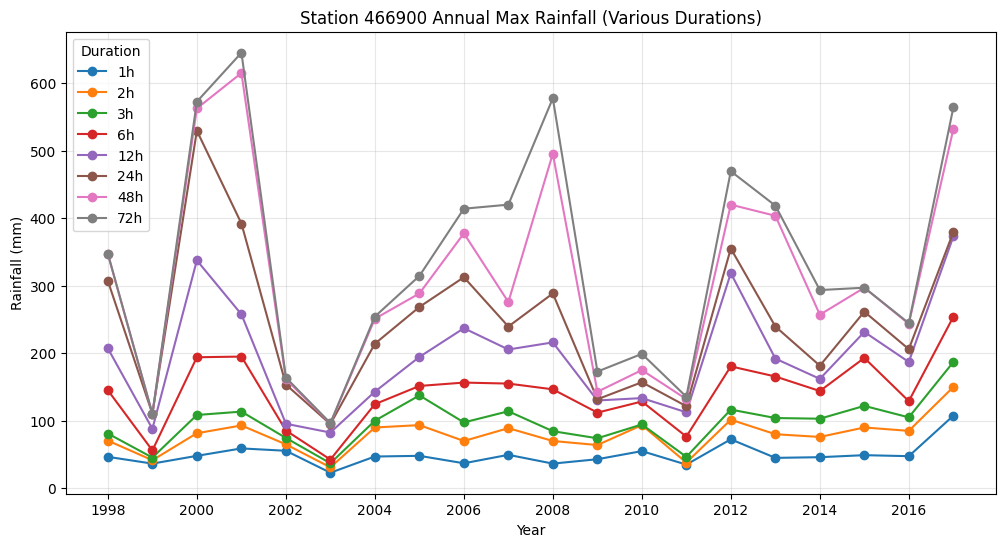

In [25]:
# 以折線圖呈現指定測站的年度最大雨量趨勢。

import matplotlib.pyplot as plt
import datetime as dt

plot_station = "466900"  # 想要檢視的測站，可自行修改
plot_df = conn.execute(
    """
    SELECT *
    FROM annual_maxima_wide
    WHERE station_no = ?
    ORDER BY year
    """,
    [plot_station],
).fetchdf()

value_cols = [col for col in plot_df.columns if col.startswith('max_')]

if plot_df.empty:
    print(f"測站 {plot_station} 無資料或未達覆蓋率條件。")
else:
    plt.figure(figsize=(12, 6))
    for col in sorted(value_cols, key=lambda x: int(x.split('_')[1][:-1])):
        label = col.replace('max_', '').replace('h_mm', 'h')
        plt.plot(plot_df['year'], plot_df[col], marker='o', label=label)
    plt.title(f"Station {plot_station} Annual Max Rainfall (Various Durations)")
    plt.xlabel('Year')
    plt.ylabel('Rainfall (mm)')
    plt.legend(title='Duration')
    plt.grid(True, alpha=0.3)
    plt.show()


In [26]:
conn.close()